# YouTube Trending Videos Statistical Analysis

## INTRODUCTION

#### to be edited</b>
<b>https://www.kaggle.com/rsrishav/youtube-trending-video-dataset

In [1]:
# Importing libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp

%matplotlib inline

In [2]:
'''
Later on we can also remove the ones we wouldn't use
'''
# Importing dataset
data_gb = pd.read_csv("../data/GB_youtube_trending_data.csv",sep=",")  #uk  
data_fr = pd.read_csv("../data/FR_youtube_trending_data.csv",sep=",")  #france
data_us = pd.read_csv("../data/US_youtube_trending_data.csv",sep=",")  #usa 
data_ru = pd.read_csv("../data/RU_youtube_trending_data.csv",sep=",")  #russia
data_de = pd.read_csv("../data/DE_youtube_trending_data.csv",sep=",")  #germany 
data_ca = pd.read_csv("../data/CA_youtube_trending_data.csv",sep=",")  #canada   
data_kr = pd.read_csv("../data/KR_youtube_trending_data.csv",sep=",")  #southkorea   
data_jp = pd.read_csv("../data/JP_youtube_trending_data.csv",sep=",")  #japan
data_br = pd.read_csv("../data/BR_youtube_trending_data.csv",sep=",")  #brazil
data_mx = pd.read_csv("../data/MX_youtube_trending_data.csv",sep=",")  #mexico

In [3]:
'''
This can stay for now to easily see what are our properties in the dataset. We can delete it once
we are familiar with the dataset
'''
brief_list_col = []
brief_list = []

for i in range(0,len(data_gb.columns)):
    brief_list_col.append(data_gb.columns[i])
    brief_list.append(data_gb[data_gb.columns[i]][0])

brief_df = pd.DataFrame(brief_list_col,columns=["Property"])
brief_df.insert(1,"Output",brief_list,True)
brief_df

,Property,Output
0,video_id,J78aPJ3VyNs
1,title,I left youtube for a month and THIS is what ha...
2,publishedAt,2020-08-11T16:34:06Z
3,channelId,UCYzPXprvl5Y-Sf0g4vX-m6g
4,channelTitle,jacksepticeye
5,categoryId,24
6,trending_date,2020-08-12T00:00:00Z
7,tags,jacksepticeye|funny|funny meme|memes|jacksepti...
8,view_count,2038853
9,likes,353790


                                       **INDIVIDUAL PARTS**

### Data Cleaning & Wrangling

In [4]:
# Adding json file
gb_json = pd.read_json('../data/GB_category_id.json')

In [5]:
# Flattening json file to get rid of dict format
col_list = ["items","items_snippet"]

def flat_func(df,column):
    for column in col_list:
        flatten = pd.DataFrame(dict(df[column])).transpose()
        columns = [str(i) for i in flatten.columns]
        flatten.columns = [column + "_" + str(colname) for colname in columns]
        df = pd.concat([df,flatten],axis=1)
        df = df.drop(column,axis=1)
    return df

gb_flat = flat_func(gb_json,col_list)[["items_id","items_snippet_title"]]

In [6]:
# Adding trends next to categoryId's, could be useful for further analysis
'''
categoryId 29 is missing in JSON file so I am going to remove rows with categoryId 29 in order to run 
below code. There are only 3 rows available with categoryId 29, so shouldn't be a problem at all.
'''
drop_idx = data_gb[data_gb.categoryId == 29].index
data_gb = data_gb.drop(drop_idx)

trend = []
for i in data_gb["categoryId"]:
    for j in range(0,len(gb_flat)):
        if i == int(gb_flat["items_id"][j]):
            trend.append(gb_flat["items_snippet_title"][j])

data_gb.insert(6,"trend",trend)

In [7]:
# Scrapping the most updated row for each link
latest_idx = []
for link in np.array(data_gb["video_id"].unique()):
    latest_row = data_gb[(data_gb["video_id"] == 
                          link)][["view_count"]].nlargest(1,"view_count").index[0]
    latest_idx.append(latest_row)

# Re-creating database based on unique video_id's (the most recent column is taken)
data_gb_unique = data_gb[data_gb.index.isin(latest_idx)]

### Data Analysis

In [8]:
'''
No null values.
'''
data_gb_unique.isnull().sum()

video_id              0
title                 0
publishedAt           0
channelId             0
channelTitle          0
categoryId            0
trend                 0
trending_date         0
tags                  0
view_count            0
likes                 0
dislikes              0
comment_count         0
thumbnail_link        0
comments_disabled     0
ratings_disabled      0
description          23
dtype: int64

In [9]:
'''
For quick look. Will be deleted.
'''

data_gb_numerical = data_gb_unique[["view_count","likes","dislikes","comment_count"]]
data_gb_unique_pivot_table = pd.pivot_table(data_gb_unique,values=(["view_count","likes",
                                                                    "dislikes","comment_count"])
                                            ,aggfunc="sum",index="trend")
data_gb_unique_pivot_table

,comment_count,dislikes,likes,view_count
trend,,,,
Autos & Vehicles,260805,44400,3191581,55917651
Comedy,1057001,206928,17952077,206142921
Education,401346,61893,4853841,74887276
Entertainment,5474915,1384350,68352753,1091820159
Film & Animation,560603,155201,7017811,143054112
Gaming,2190586,731890,24188088,509275146
Howto & Style,479648,209799,6753120,114483319
Music,24306545,4679051,162292594,2336477998
News & Politics,485364,169690,1088567,79180012


In [10]:
'''
Checking correlations between numerical columns.
'''
data_gb_numerical.corr()

,view_count,likes,dislikes,comment_count
view_count,1.000000,0.932037,0.846647,0.777414
likes,0.932037,1.000000,0.792857,0.788863
dislikes,0.846647,0.792857,1.000000,0.735443
comment_count,0.777414,0.788863,0.735443,1.000000


### Data Visualization

In [11]:
# Setting plot parameters

plt.rcParams["font.family"] = "agency fb"
plt.rcParams["figure.figsize"] = (14,7)

Text(0.5, 1.0, 'Correlation Heatmap of UK')

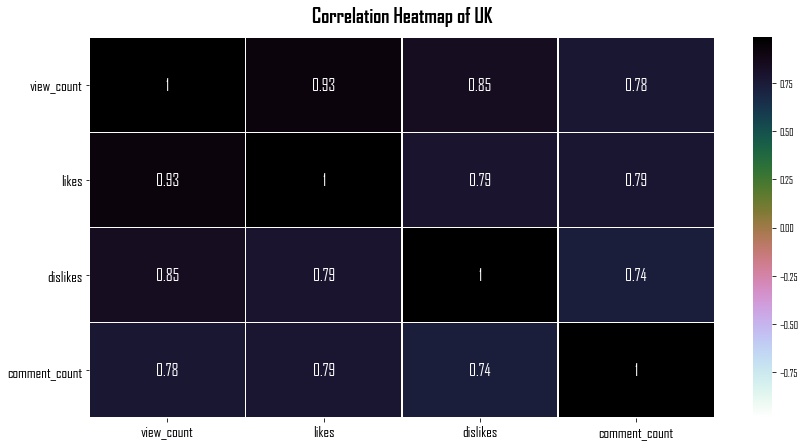

In [12]:
'''
As we have seen before, view_count,likes,dislikes and comment_counts are highly correlated between
each other.

Yet, even though most of them tend to be a strong correlation, the weakest amongst them belong to
correlation between view_count vs. comment_count. I believe this is because for people 
liking/disliking the video is much easier & faster rather than spending few minutes to comment.
'''

# Checking correlation with heatmap

sns.heatmap(data_gb_numerical.corr(),annot=True,annot_kws={"size": 16},
            vmin=-0.99,vmax=0.99,cbar=True,linewidth=0.5, cmap="cubehelix_r")
plt.xticks(size=15)
plt.yticks(rotation=0,size=15)
plt.title("Correlation Heatmap of UK",size=20,fontweight="bold",pad=15)

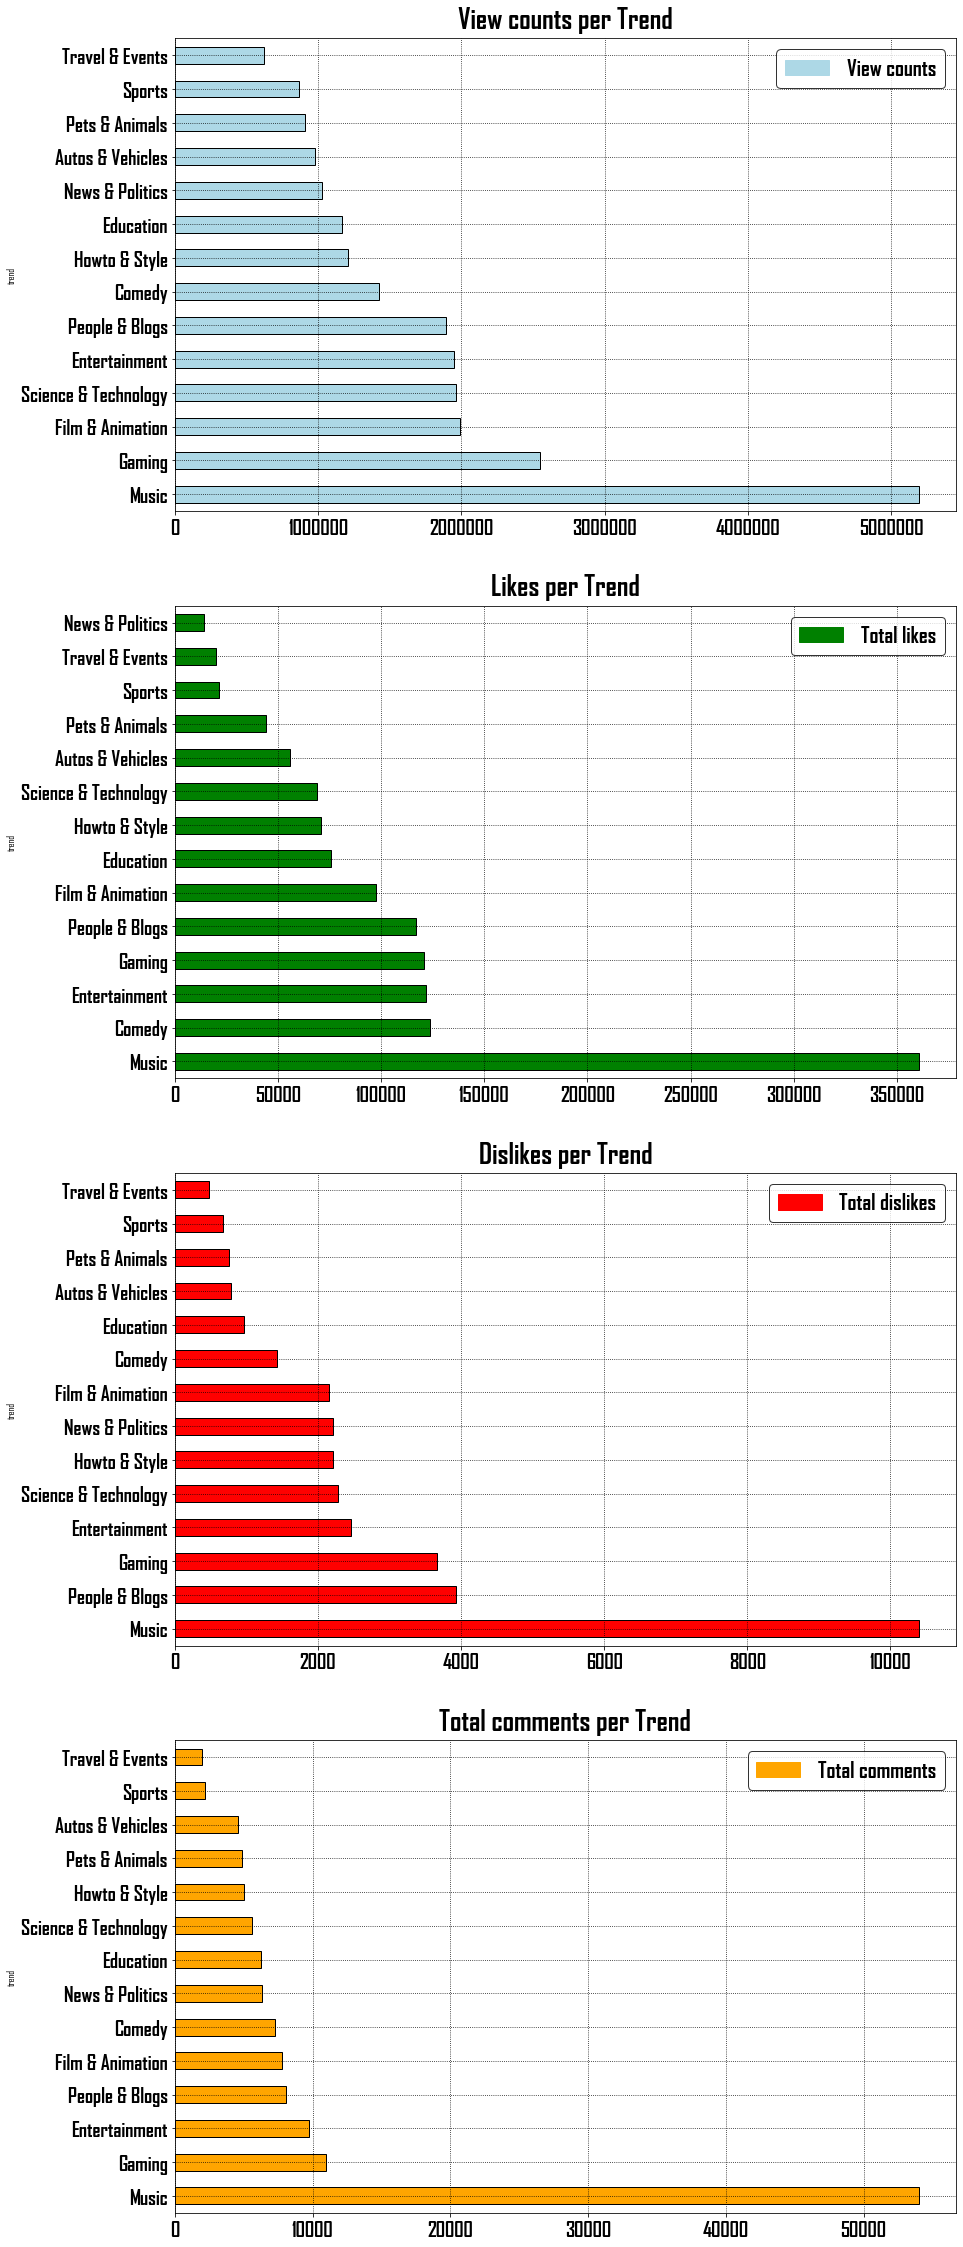

In [13]:
data_gb_numerical_categorized = data_gb_unique[["view_count",
                                                "likes","dislikes","comment_count","trend"]]

data_gb_numerical_categorized_pivot_table = pd.pivot_table(data_gb_unique,
                                                           values=("view_count","likes",
                                                                    "dislikes","comment_count",
                                                                  ),index="trend")

# Setting plot properties
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams["figure.figsize"] = (14,40)




fig1, ax = plt.subplots(4,1)



'''
# Drawing view_count vs trends plot in subplot 0
'''

data_gb_numerical_categorized_pivot_table[["view_count"]].sort_values(
    by="view_count",ascending=False).plot.barh(
    ax=ax[0],stacked=True,edgecolor="k",lw=1,color="lightblue")


ax[0].set_title("View counts per Trend",size=28,fontweight="bold",pad=10,color="k")


likes_legend = mpatches.Patch(color='lightblue', label='View counts')
ax[0].legend(handles=[likes_legend],edgecolor="k",prop={"size":22})

ax[0].grid(True,color="k",ls=":")

# only different step from the rest
ax[0].get_xaxis().get_major_formatter().set_scientific(False)   # to close scientific notation 

'''
# Drawing total likes vs trends plot in subplot 1
'''

data_gb_numerical_categorized_pivot_table[["likes"]].sort_values(
    by="likes",ascending=False).plot.barh(
    ax=ax[1],stacked=True,edgecolor="k",lw=1,color="green")


ax[1].set_title("Likes per Trend",size=28,fontweight="bold",pad=10,color="k")


likes_legend = mpatches.Patch(color='green', label='Total likes')
ax[1].legend(handles=[likes_legend],edgecolor="k",prop={"size":22})

ax[1].grid(True,color="k",ls=":")


'''
# Drawing total dislikes vs trends plot in subplot 2
'''

data_gb_numerical_categorized_pivot_table[["dislikes"]].sort_values(
    by="dislikes",ascending=False).plot.barh(
    ax=ax[2],stacked=True,edgecolor="k",lw=1,color="red")


ax[2].set_title("Dislikes per Trend",size=28,fontweight="bold",pad=10,color="k")


dislikes_legend = mpatches.Patch(color='red', label='Total dislikes')
ax[2].legend(handles=[dislikes_legend],edgecolor="k",prop={"size":22})

ax[2].grid(True,color="k",ls=":")

'''
# Drawing total comment_count vs trends plot in subplot 3
'''

data_gb_numerical_categorized_pivot_table[["comment_count"]].sort_values(
    by="comment_count",ascending=False).plot.barh(
    ax=ax[3],stacked=True,edgecolor="k",lw=1,color="orange")


ax[3].set_title("Total comments per Trend",size=28,fontweight="bold",pad=10,color="k")


dislikes_legend = mpatches.Patch(color='orange', label='Total comments')
ax[3].legend(handles=[dislikes_legend],edgecolor="k",prop={"size":22})

ax[3].grid(True,color="k",ls=":")

In [17]:
data_gb_unique_pivot_table.reset_index().sort_values(by="view_count",ascending=False).reset_index()

,index,trend,comment_count,dislikes,likes,view_count
0,7,Music,24306545,4679051,162292594,2336477998
1,3,Entertainment,5474915,1384350,68352753,1091820159
2,12,Sports,1477110,445533,14271923,576541420
3,5,Gaming,2190586,731890,24188088,509275146
4,9,People & Blogs,1589696,773994,22989001,372969095
5,11,Science & Technology,696334,283412,8575920,243477653
6,1,Comedy,1057001,206928,17952077,206142921
7,4,Film & Animation,560603,155201,7017811,143054112
8,6,Howto & Style,479648,209799,6753120,114483319
9,8,News & Politics,485364,169690,1088567,79180012


Possible hypothesis;

more popular the video more like/less dislike,
tbc